# How to preprocess a mixed dataset for machine learning

** What is preprocessing? **  
Preprocessing describes the process of cleaning and converting a 'raw' (i.e. unprocessed) dataset into a clean dataset.


When given a dataset, the preprocessing can have various steps depending on  
a) what type of data you're looking at (text, images, time series, ...)  
b) what models you want to train

In this notebook we will look at a **dataset with both numerical and cateogorical attributes**.

## Possible preprocessing steps

As mentioned already, the preprocessing steps you will need for your dataset depend on the nature of the dataset and models you want to train. Possible preprocessing steps are:

- Rescaling attributes with different scales
- Standardizing the dataset
- Encoding categorial attributes with integer values
- Handling missing data
- Removing duplicated data points
- Removing outliers/ handle noisy data
- Discretize the data
- Split the dataset into a training and test set

## The Pima Indians Diabetes Dataset

In this notebook we will work with the Pima Indians Diabetes Dataset. The dataset has 9 attributes:

| Attribute name | Description 
| --------------| ---------------------------|
| Pregnancies | Number of times pregnant
| Glucose | Plasma glucose concentration a 2 hours in an oral glucose tolerance test
| Blood pressure | Diastolic blood pressure (mm Hg)
| Skin thickness | Triceps skin fold thickness (mm)
| Insulin | 2-Hour serum insulin (mu U/ml)
| BMI | Body mass index
| Diabetes pedigree function | Diabetes pedigree function
| Age | Age in years
| Diagnosis | 0 or 1 (0: no diabetes, 1: diabetes)



Further information about the dataset can be found [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

## Downloading the dataset

The diabetes dataset is available on several websites. We will use the version provided by [Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). 

For datasets with multiple attributes a pandas DataFrame is the most convenient format. Therefore, we will use pandas to download our data and put it into a DataFrame.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os

%matplotlib inline

In [2]:
#data_path = os.path.expanduser('~/ml_basics/data/diabetes.csv')
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv')#, names=column_names)
column_names = df.columns.tolist()

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

## Inspecting the dataset

Two pandas functions make it very easy to take a first look at the dataset: ```DataFrame.describe()``` and ```DataFrame.info()```. From the current [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html)


``` DataFrame.info() ```   
Print a concise summary of a DataFrame.   

``` DataFrame.describe():```  
Generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.   
Analyzes both numeric and object series, as well as DataFrame column sets of mixed data types. The output will vary depending on what is provided. Refer to the notes below for more detail.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can see that there are 768 instances in the dataset, which is very small for a machine learning dataset. For most algorithms you will need more data. 

In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The variables *count, mean, std* and *max* are self-explanatory. Using the minimum values we can already see that the minimum value of many attributes is 0. For the "pregnancies" attribute this makes sense. However, for attributes like "blood pressure" or "insulin" is doesn't. This  indicates that certain values are missing.

The rows named *25%, 50%* and *75%* represent the corresponding *percentiles*. For example, 25% of the woman had less than 1 pregnancy, 50% had less than 3 pregnancies and 75% had less than 6 pregnancies. 

## Visualizing aspects of the dataset

Another way to get familiar with the dataset is to look at all numerical attributes and plot a histogram for each of them.

> What is a histogram?   
> A histogram is a graphical representation of data that uses bars of different heights. It groups data points into value ranges. The exact shape of the value ranges depends on the number of bars. With a lot of bars, value ranges will be small, with only a few bars they will be wider. The height of a bar (y-axis) represents the number of data points that fall into the corresponding value range (x-axis). 

Since our dataset has only numerical values we can simply call the ```DataFrame.hist()``` function (see section "Encoding categorical attributes" for more details on how to convert categorical to numerical attributes).

```DataFrame.hist()``` calls matplotlib.pyplot.hist() on each series in the DataFrame, resulting in one histogram per column (i.e. one histogram per attribute).

The histograms will also make it easier to detect outliers or erroneous values (see section "Handling noisy data" for more details).

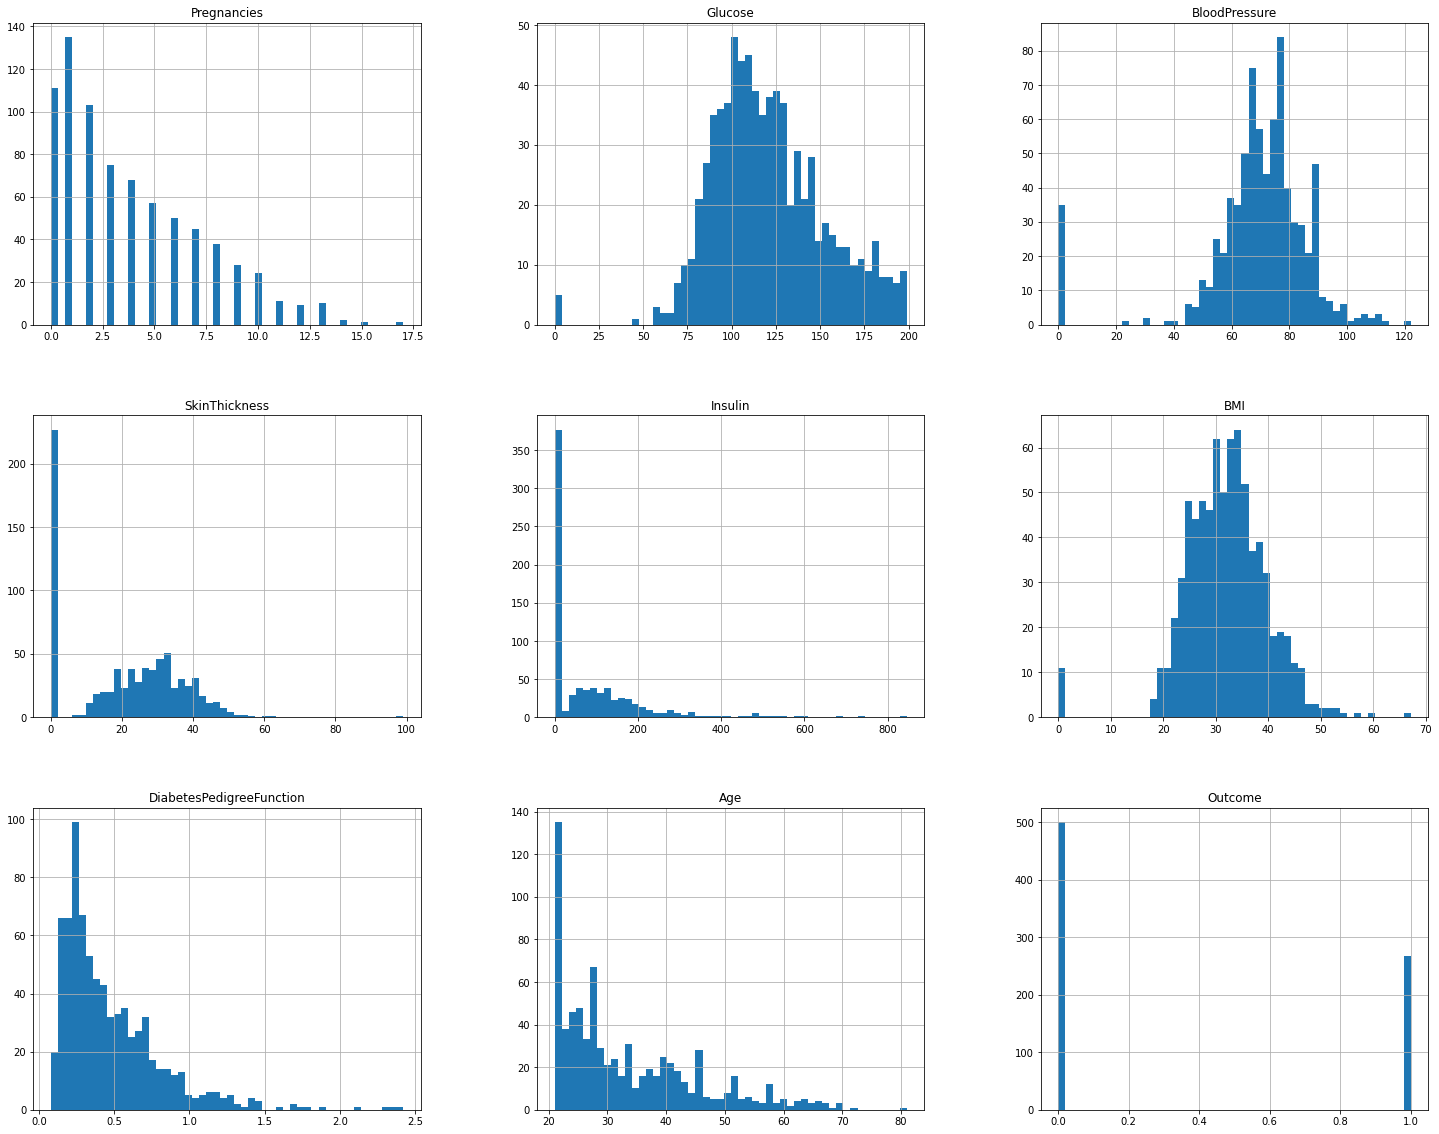

In [6]:
df.hist(bins=50, figsize=(25, 20))
plt.show()

We can observe several things in these histograms:

1. Some entries have the "insulin" and/or "skin_thickness" attribute set to zero. As mentioned before, this indicates that certain values are missing.
2. The attributes have different scales. We will see later how to handle this.
3. Some histograms extend further to the left of the median than to the right. Other histograms are more centered. We will discuss at a later point how these different distributions can be handeled.

## Removing duplicated data points

To make sure that none of the data point are duplicated and hence overrepresented, we can scan the dataset for duplicated entries and delete them. This becomes very easy with the ```DataFrame.drop_duplicates()``` function.

In [7]:
df.drop_duplicates(keep='first', inplace=True)

In [8]:
df.shape

(768, 9)

## Creating a test set

If you want to train a machine learning model on your data it's important that you create a separate test set BEFORE you do any further preprocessing. The test set is put aside and not looked at, it's sole purpose is to allow for an evaluation of the trained classifier.

Creating a test set is very easy using scikit-learn. We will use 20% of the data as a test set.

In [9]:
original_train_df, test_df = train_test_split(df, test_size=0.2)

# To be sure we will create a copy for further processing
train_df = original_train_df.copy() 

In [10]:
train_df.shape

(614, 9)

In [11]:
test_df.shape

(154, 9)

## Gaining further insight

To further improve our understanding of the dataset, we can add a few more exploration steps. Besides creating more plots, another useful thing is looking for *correlations* between the attributes. 

For example, we can compute [Pearson's correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). From the linked Wikipedia website:

> Pearson's correlation coefficient is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

A 'total positive linear correlation' means that as X increases, Y increases. A 'total negative linear correlation' means that as X increases, Y *decreases*.

We can easily compute Pearson's correlation coefficient between every pair of attributes using ```DataFrame.corr()```. In fact, ```DataFrame.corr()``` could also be used to compute the Kendall Tau correlation coefficient or  Spearman rank correlation.

In [12]:
correlation_matrix = train_df.corr(method='pearson')

correlation_matrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.134527,0.108597,-0.074399,-0.056369,0.020305,-0.053354,0.527978,0.216118
Glucose,0.134527,1.000000,0.168195,0.085055,0.350060,0.247764,0.144049,0.248397,0.453494
BloodPressure,0.108597,0.168195,1.000000,0.224574,0.092534,0.317143,0.043972,0.224908,0.072450
SkinThickness,-0.074399,0.085055,0.224574,1.000000,0.428072,0.404296,0.187061,-0.100267,0.110235
Insulin,-0.056369,0.350060,0.092534,0.428072,1.000000,0.179549,0.192410,-0.035975,0.153700
BMI,0.020305,0.247764,0.317143,0.404296,0.179549,1.000000,0.143176,0.041845,0.303284
DiabetesPedigreeFunction,-0.053354,0.144049,0.043972,0.187061,0.192410,0.143176,1.000000,0.024229,0.159731
Age,0.527978,0.248397,0.224908,-0.100267,-0.035975,0.041845,0.024229,1.000000,0.196226
Outcome,0.216118,0.453494,0.072450,0.110235,0.153700,0.303284,0.159731,0.196226,1.000000


Let's take a look at how each attribute correlates with the final diagnosis

In [13]:
correlation_matrix["Outcome"].sort_values()

BloodPressure               0.072450
SkinThickness               0.110235
Insulin                     0.153700
DiabetesPedigreeFunction    0.159731
Age                         0.196226
Pregnancies                 0.216118
BMI                         0.303284
Glucose                     0.453494
Outcome                     1.000000
Name: Outcome, dtype: float64

The highest correlation exists for the attribute "glucose" but none of these correlations are very high. However, it's important that we keep in mind that Pearson's only measures *linear* correlations. Nonlinear correlations are not measured and might still exist!

Tip: if you want to take a closer look at correlations and create some plots consider pandas [scatter matrix](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html) function.

## Handling missing data

To make sure that we don't mistake missing values as being 0, we will replace them with 'NaN' (short for "not a number"). We need to handle missing values in the columns 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function' and 'age'.

In [14]:
names = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for name in names:
    train_df[name].replace(0, np.nan, inplace=True)

In [15]:
train_df.head(8)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
393,4,116.0,72.0,12.0,87.0,22.1,0.463,37,0
155,7,152.0,88.0,44.0,NaN,50.0,0.337,36,1
158,2,88.0,74.0,19.0,53.0,29.0,0.229,22,0
167,4,120.0,68.0,NaN,NaN,29.6,0.709,34,0
279,2,108.0,62.0,10.0,278.0,25.3,0.881,22,0
628,5,128.0,80.0,NaN,NaN,34.6,0.144,45,0
589,0,73.0,NaN,NaN,NaN,21.1,0.342,25,0
683,4,125.0,80.0,NaN,NaN,32.3,0.536,27,1


Missing attribute values can be handled in several ways. For example we can:
- Delete or ignore the data points with missing values
- Replace the missing values, for example with the median of the corresponding attribute
- Remove the entire attribute from the dataset

We will stick to the second option. This means that we first compute the median of each attribute. In a second step we replace missing values with the corresponding attribute median, using ```DataFrame.fillna()```.

A more advanced way to do this, which avoids computing each median manually is scikit-learn's [imputer class](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html).

In [16]:
glucose_median = train_df["Glucose"].median()
blood_pressure_median = train_df["BloodPressure"].median()
skin_thickness_median = train_df["SkinThickness"].median()
insulin_median = train_df["Insulin"].median()
bmi_median = train_df["BMI"].median()
age_median = train_df["Age"].median()
dpf_median = train_df['DiabetesPedigreeFunction'].median()

train_df["Glucose"].fillna(glucose_median, inplace=True)
train_df["BloodPressure"].fillna(blood_pressure_median, inplace=True)
train_df["SkinThickness"].fillna(skin_thickness_median, inplace=True)
train_df["Insulin"].fillna(insulin_median, inplace=True)
train_df["BMI"].fillna(bmi_median, inplace=True)
train_df["Age"].fillna(age_median, inplace=True)
train_df["DiabetesPedigreeFunction"].fillna(dpf_median, inplace=True)

In [18]:
train_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
393,4,116.0,72.0,12.0,87.0,22.1,0.463,37,0
155,7,152.0,88.0,44.0,125.5,50.0,0.337,36,1
158,2,88.0,74.0,19.0,53.0,29.0,0.229,22,0
167,4,120.0,68.0,29.5,125.5,29.6,0.709,34,0
279,2,108.0,62.0,10.0,278.0,25.3,0.881,22,0


## Handling noisy data and outliers

It might happen that some entries of our dataset are noisy or that the dataset contains outliers. For example, the blood pressure of some person might be extremely high if they suffer from hypertension. Outliers might also represent **erroneous values**. For example, the age attribute should lie above 120.

Outliers can be detected in different ways. For the age attribute we could simply check the statistics given by ```df.describe()``` and check if the min and max values are reasonable. The same holds for other attributes. If you know in which range the attribute values should lie, you can quickly test if the dataset values are within that range.

Once you detect outliers you can decide how you want to deal with them. For example, you could remove them.

## Encoding categorical attributes

This dataset does not contain categorical attributes. Therefore, we don't have to encode them with integer ID's. 

For the sake of understanding, let's walk through an example with categorical attributes. Suppose our dataset had an additional column, listing the fitness of each individual. The "fitness" attribute has 4 possible values: "bad", "moderate", "good", "very good". 

In [19]:
# Copy original dataframe and add new column with random fitness values
temp_df = train_df.copy()
fitness_values = ["bad", "moderate", "good", "very good",]
temp_df['fitness'] = np.random.choice(fitness_values, temp_df.shape[0])

temp_df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,fitness
393,4,116.0,72.0,12.0,87.0,22.1,0.463,37,0,bad
155,7,152.0,88.0,44.0,125.5,50.0,0.337,36,1,bad
158,2,88.0,74.0,19.0,53.0,29.0,0.229,22,0,good
167,4,120.0,68.0,29.5,125.5,29.6,0.709,34,0,very good
279,2,108.0,62.0,10.0,278.0,25.3,0.881,22,0,moderate


In [20]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 393 to 109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    float64
 2   BloodPressure             614 non-null    float64
 3   SkinThickness             614 non-null    float64
 4   Insulin                   614 non-null    float64
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
 8   Outcome                   614 non-null    int64  
 9   fitness                   614 non-null    object 
dtypes: float64(6), int64(3), object(1)
memory usage: 52.8+ KB


Most machine learning algorithms work with numerical data, so whenever you have categorical attributes with text labels it can be useful to convert the labels into numbers. In our case, we could encode the text labels as follows: {"bad": 0, "moderate": 1, "good": 2, "very good": 3}. This can easily be done using scikit-learn's [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
fitness_encoded = encoder.fit_transform(temp_df["fitness"])

for id_, class_ in enumerate(encoder.classes_):
    print(f"class id {id_} has label {class_}")

print()
print(f"Encoded fitness values for first 10 entries: {fitness_encoded[:10]}")

class id 0 has label bad
class id 1 has label good
class id 2 has label moderate
class id 3 has label very good

Encoded fitness values for first 10 entries: [0 0 1 3 2 0 1 0 0 2]


In [22]:
type(fitness_encoded)

numpy.ndarray

In [23]:
temp_df['fitness'] = fitness_encoded
temp_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,fitness
393,4,116.0,72.0,12.0,87.0,22.1,0.463,37,0,0
155,7,152.0,88.0,44.0,125.5,50.0,0.337,36,1,0
158,2,88.0,74.0,19.0,53.0,29.0,0.229,22,0,1
167,4,120.0,68.0,29.5,125.5,29.6,0.709,34,0,3
279,2,108.0,62.0,10.0,278.0,25.3,0.881,22,0,2


In [24]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 393 to 109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    float64
 2   BloodPressure             614 non-null    float64
 3   SkinThickness             614 non-null    float64
 4   Insulin                   614 non-null    float64
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
 8   Outcome                   614 non-null    int64  
 9   fitness                   614 non-null    int64  
dtypes: float64(6), int64(4)
memory usage: 52.8 KB


An disadvantage of an integer encoding like {"bad": 0, "moderate": 1, "good": 2, "very good": 3} arises from the functioning of some machine learning algorithms: when comparing different data points, two nearby values (e.g. 2 and 3) will be considered more "similar" than distant values (like 0 and 3) although the corresponding categories might not necessarily be similar to each other. 

Another possibility (which solves the just mentioned problem) would be to create a *one-hot encoding* of the attribute values. In our case this means that each text label would become a binary attribute, e.g. "bad fitness", "moderate fitness", "good fitness" and "very good fitness". The labels would simply be 0 or 1.

For example, if a person has a "good" fitness, the attributes "bad fitness", "moderate fitness" and "very good fitness" would be set to 0, the "good fitness" attribute to 1.

To create one-hot encoded labels we could use scikit-learn's [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html).

## Rescaling or standardizing attributes

Several algorithms are sensitive to the *scale* of numerical attributes and won't perform well if the attributes have very different scales. 

A classical example is the [k-nearest-neighbor algorithm](https://github.com/zotroneneis/machine_learning_basics/blob/master/k_nearest_neighbour.ipynb). When having an attribute "age" that ranges from 0 to 100 and an attribute "income" that ranges from 1 to 1.000.000, the attribute with the larger range will have a higher influence on the result.

Therefore, whenever having attributes with different scales, make sure to rescale them. Two standard ways of rescaling are [min-max scaling](https://en.wikipedia.org/wiki/Feature_scaling) and [standardization](https://en.wikipedia.org/wiki/Feature_scaling).

In min-max scaling each feature value is rescaled to be in the range from 0 to 1. The formula for applying min-max scaling to some attribute value $x_i$ is:   

$x'_i = \frac{x_i - min(x)}{max(x) - min(x)}$

with $min(x)$ being the minimum value of attribute $x$ and $x'_i$ being the rescaled value of $x_i$.

To perform min-max scaling we can use scikit-learn's [MinMax Scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). 

In [25]:
from sklearn.preprocessing import MinMaxScaler

# initialize min-max scaler
mm_scaler = MinMaxScaler()

temp1_df = train_df.copy()
column_names = temp1_df.columns.tolist()

# transform all attributes
temp1_df[column_names] = mm_scaler.fit_transform(temp1_df[column_names])

temp1_df.sort_index(inplace=True)
temp1_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.675325,0.489796,0.304348,0.134014,0.314928,0.234415,0.483333,1.0
1,0.058824,0.266234,0.428571,0.239130,0.134014,0.171779,0.116567,0.166667,0.0
3,0.058824,0.292208,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0.0
4,0.000000,0.603896,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1.0
6,0.176471,0.220779,0.265306,0.271739,0.088942,0.261759,0.072588,0.083333,1.0


Note: it's important that you fit the scaler only on the TRAINING set (not the test set!)

The other approach, called **standardization** transform attributes such that they're distributed according to a standard normal distribution with mean 0 and standard deviation 1.   
The formula for standardizing some attribute value $x_i$ is:   

$x'_i = \frac{x_i - mean(x)}{\sigma(x)}$

with $mean(x)$ being the mean of attribute $x$, $\sigma(x)$ being the standard deviation of attribute $x$ and $x'_i$ being the rescaled value of $x_i$.

To perform standardization we can use scikit-learn's [Standard Scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

In [26]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

temp2_df = train_df.copy()

# transform all attributes
temp2_df[column_names] = mm_scaler.fit_transform(temp2_df[column_names])
temp2_df.sort_index(inplace=True)
temp2_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.675325,0.489796,0.304348,0.134014,0.314928,0.234415,0.483333,1.0
1,0.058824,0.266234,0.428571,0.239130,0.134014,0.171779,0.116567,0.166667,0.0
3,0.058824,0.292208,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0.0
4,0.000000,0.603896,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1.0
6,0.176471,0.220779,0.265306,0.271739,0.088942,0.261759,0.072588,0.083333,1.0


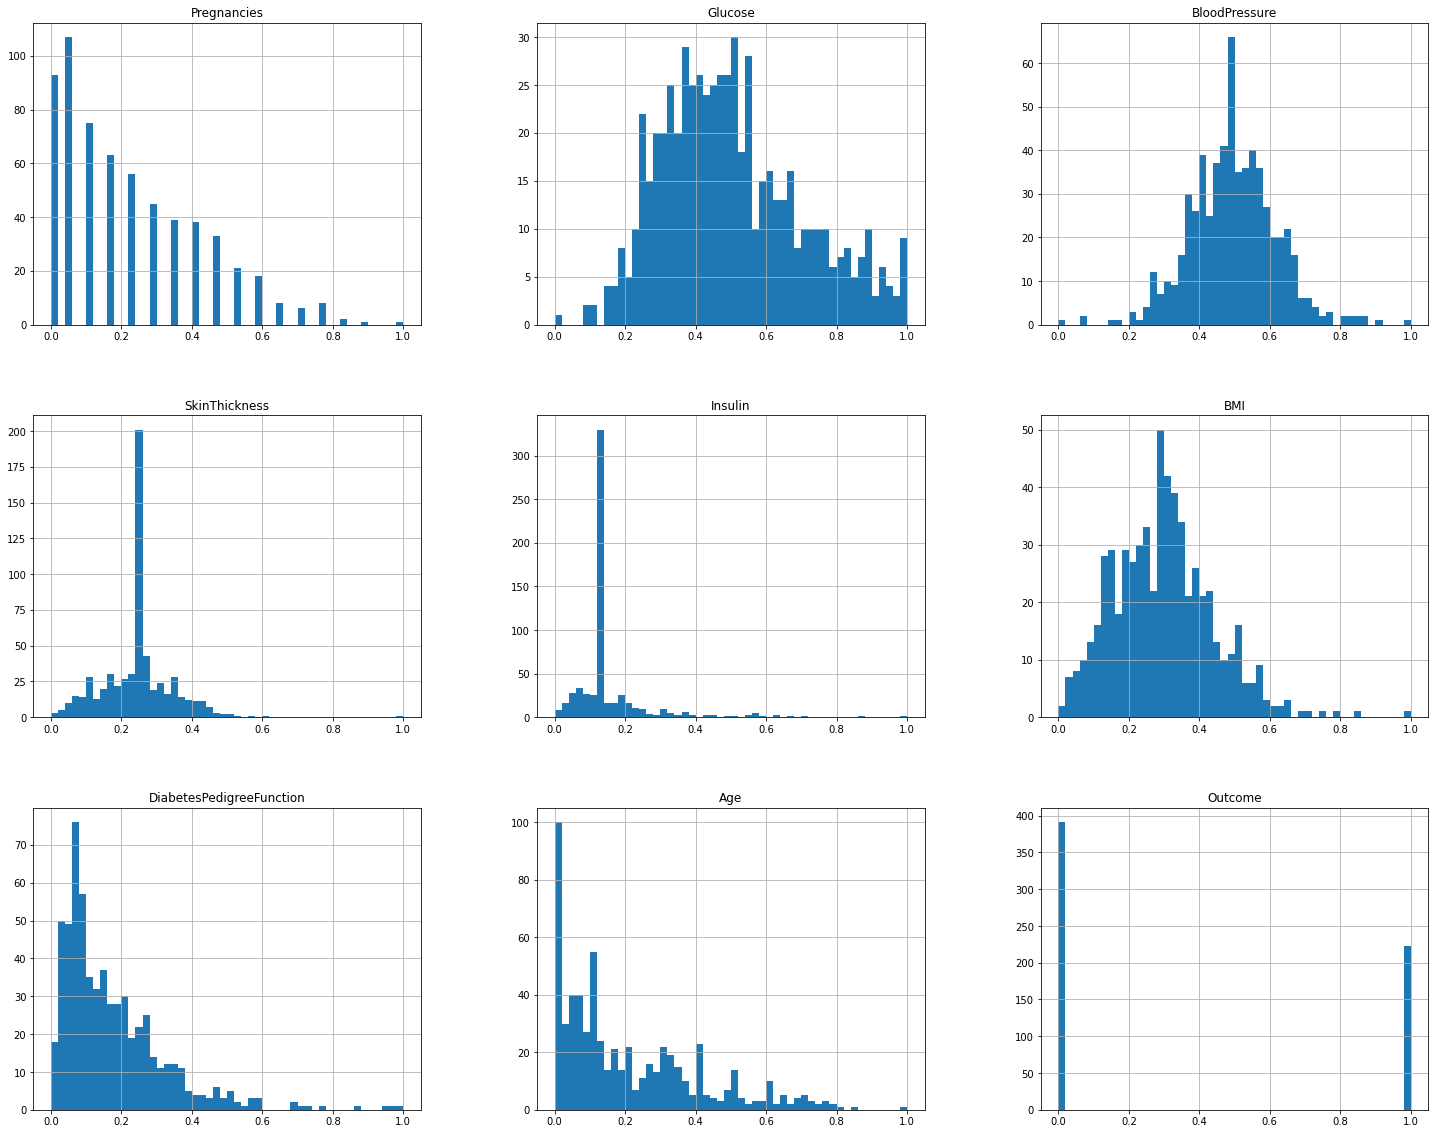

In [27]:
temp2_df.hist(bins=50, figsize=(25, 20))
plt.show()

These steps should be enough to get us started with training machine learning models on the data. If you want to know more about those, check out the other notebooks!

## Practice

#### Think about the below dataset

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
